# Starbucks Capstone Challenge
# Predicting Customer Offer Success

### Project Overview

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set contains **simplified/simulated** data that mimics customer behavior on the Starbucks rewards mobile app. 

Every few days, each customer with the Starbucks mobile app would receive **personalized** offers such as a discount, BOGO (buy one get one free) or merely an advertisement for a drink. This means different users would receive different offers at different timings. Some users might not receive any offer during certain weeks. 

This project will combine (1) transaction, (2) demographic and (3) offer data to determine which demographic groups respond best to which offer type. A pipeline is built all the way from data cleansing, data preprocessing, data analysis, all the way to the final almagation of the data sets to serve as inputs to a machine learning model that will enable us to predict a desired outcome, which we will expand upon in the **Problem Statement** section below.

### Problem Statement and Metrics

The problem statement for the project is to build a predictive model that will determine the likelihood of a customer responding to an offer. We shall define an offer to be successful only when the customer both views an offer and meets or exceeds its difficulty within the offer's duration.

The steps involved are roughly as follows:

**Part 1: Data Exploration, Visualisation, Cleansing & Preprocessing**
  * Data Exploration/Visualisation: Perform first-pass analysis to determine necessary feature engineering.
  * Data Cleansing/Preprocessing : Remove redundant features/anomalies, categorical variable encoding, coalescing null values, etc.

**Part 2: Combining the Data Sets**
  * Combine customer transaction, demographic, offer data in 6 steps and convert into dataframe.

**Part 3: Modeling**
  * Splitting the data : Splitting data into training and test sets
  * Feature scaling: Apply min/max scaling to numeric features to avoid model bias 
  * Building Models : Using Logistic Regression and Random Forest algorithms
  * Refine Model: Apply Grid Search to improve the performance of the best model

As for the metrics, Accuracy measures model's ability to correctly predict a successful offer. However, for an imbalanced data set where success/failure is overwhelmingly biased towards one single outcome, accuracy is not a good measure of model performance. Instead of looking at the accuracy score alone, it is necessary to look at both the precision and recall metrics of the model. Therefore, the F1-score, which is a weighted average of the precision and recall metrics, would be employed.

I shall first build a logistic model, and benchmark the random forest model against it. Finally, I shall refine the parameters of the model that has the highest accuracy and F1-score.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sys
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from joblib import dump, load
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [3]:
# Reading in Datasets
portfolio  = pd.read_json('data/portfolio.json', orient='records',lines=True)
profile    = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
# Enable viewing of all columsn
pd.options.display.max_columns = 500

## Part 1: Data Exploration, Visualisation, Cleansing & Preprocessing

## Data Set 1 - Offer Portfolio
#### Data Exploration/Visualisation

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Data Cleansing and Preprocessing 
1. Renaming columns for clarity: (i) "duration" to "durationdays" (ii) "id" to "offerid"
2. Remove underscores from columns names: (i) "offertype" 
3. One-Hot-Encode: (i) "offertype"; (ii) "channels" 
4. Drop the original encoded columns in (3).

In [6]:
# Cleaning Data
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # Change Column Names
    cleaned_portfolio = portfolio.copy()
    
    cleaned_portfolio.rename(columns={"duration": "durationdays", "id": "offerid"}, inplace=True)
    
    cleaned_portfolio.columns = cleaned_portfolio.columns.str.replace('_', '')

    # One Hot Encode 'offertype' column
    offertype_df = pd.get_dummies(cleaned_portfolio['offertype'])
    
    # One Hot Encode 'channels' column
    mlb = MultiLabelBinarizer()
    mlb.fit(cleaned_portfolio['channels'])

    channels_df = pd.DataFrame(mlb.transform(cleaned_portfolio['channels']), columns=mlb.classes_)
    
    # Concatenate the New Columns and Drop the Old Columns 
    cleaned_portfolio = pd.concat([cleaned_portfolio, offertype_df, channels_df], axis=1)
    cleaned_portfolio.drop(['channels','offertype'], axis=1, inplace=True)

    # Column Ordering
    column_ordering = ['offerid','reward','difficulty','durationdays',
                       'bogo','discount','informational',
                       'email','mobile','social','web']
    
    return cleaned_portfolio[column_ordering]

# Cleaned Portfolio
portfolio = clean_portfolio(portfolio)
portfolio.head(5)

,offerid,reward,difficulty,durationdays,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,1,0,0,1


## Data Set 2 - Customer Profile
#### Data Exploration/Visualisation

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
# Total Rows
profile.shape[0]

17000

In [10]:
# Find out the Missing values
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [11]:
# Gender - Summary (excluding NULL values)
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [12]:
# Age - Summary
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

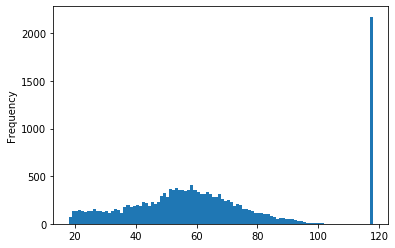

In [13]:
# Age - Histogram
profile['age'].plot.hist(bins=100)

In [14]:
# Age = 118 = for all gender=income=NAN customers
age118 = profile[profile['age'] == 118]

In [15]:
age118.count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

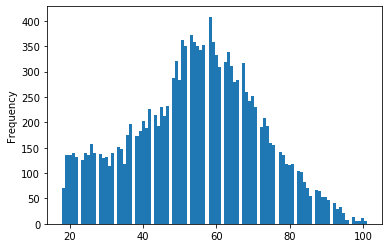

In [16]:
# Age profile after removing Age = 118
agex118 = profile[profile['age'] != 118]
agex118['age'].plot.hist(bins=100)

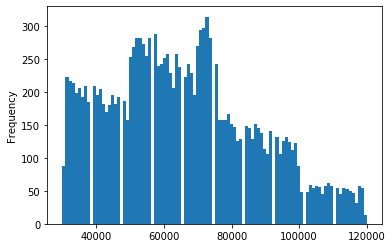

In [17]:
# Income profile after removing Age = 118
agex118['income'].plot.hist(bins=100)

In [18]:
profile.groupby('gender').id.count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

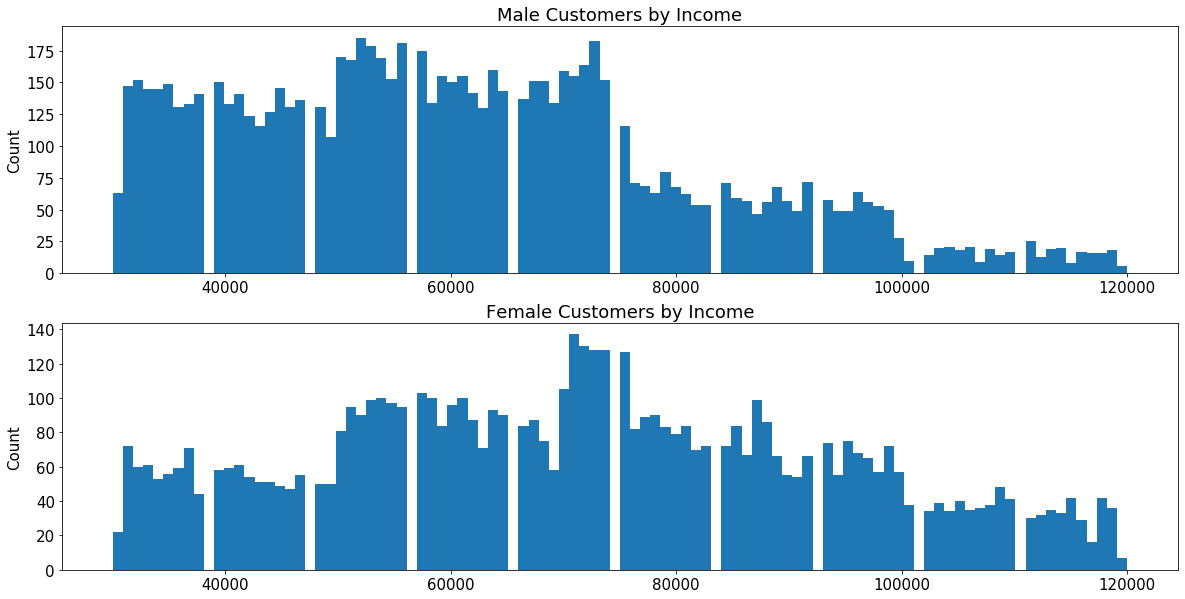

In [19]:
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']

male_x = male_customers['income'] 
female_x = female_customers['income'] 

plt.figure(figsize=(20,10))

plt.rc('font', size=15) 
plt.subplot(2, 1, 1)
plt.hist(male_x,bins=100)
plt.title('Male Customers by Income')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
plt.hist(female_x,bins=100)
plt.title('Female Customers by Income')
plt.ylabel('Count')

plt.show()

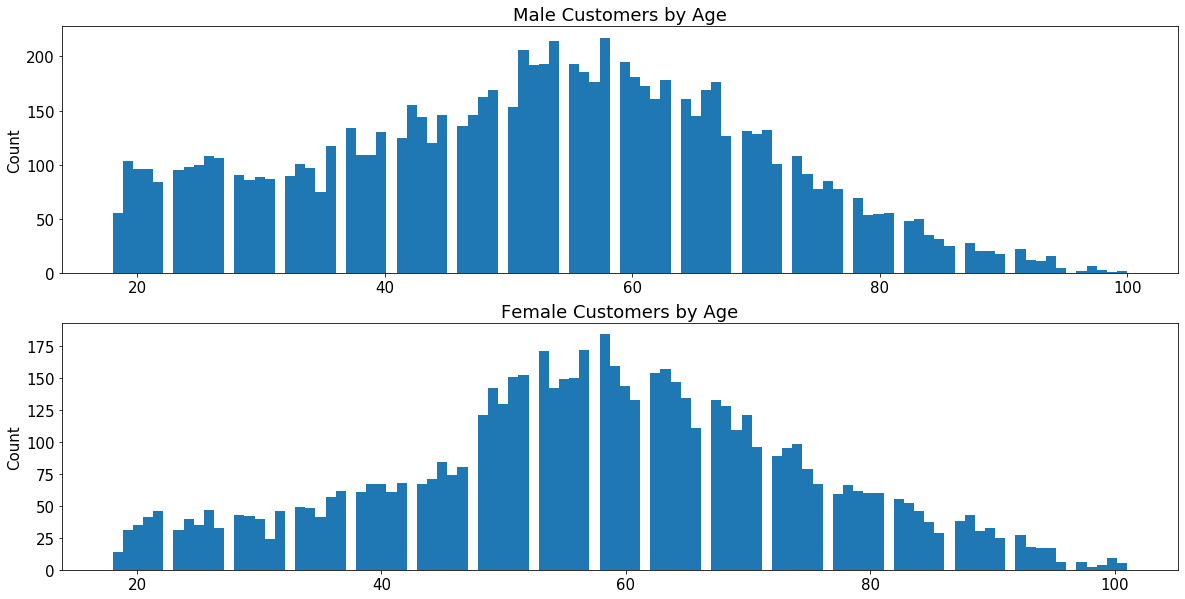

In [20]:
male_x = male_customers['age'] 
female_x = female_customers['age'] 

plt.figure(figsize=(20,10))

plt.rc('font', size=15) 
plt.subplot(2, 1, 1)
plt.hist(male_x,bins=100)
plt.title('Male Customers by Age')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
plt.hist(female_x,bins=100)
plt.title('Female Customers by Age')
plt.ylabel('Count')

plt.show()

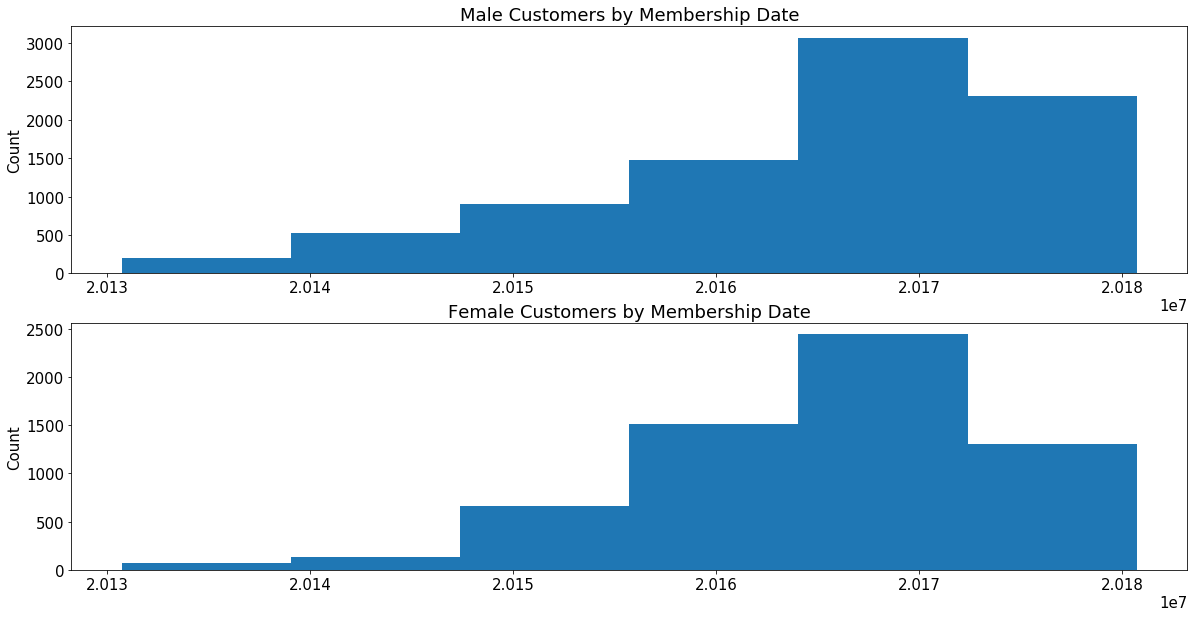

In [21]:
male_x = male_customers['became_member_on'] 
female_x = female_customers['became_member_on'] 

plt.figure(figsize=(20,10))

plt.rc('font', size=15) 
plt.subplot(2, 1, 1)
plt.hist(male_x,bins=6)
plt.title('Male Customers by Membership Date')
plt.ylabel('Count')

plt.subplot(2, 1, 2)
plt.hist(female_x,bins=6)
plt.title('Female Customers by Membership Date')
plt.ylabel('Count')

plt.show()

#### Data Cleansing and Preprocessing 

1. Remove customers with incomplete data where: (i) 'income'; (ii) 'gender' are both Null/other.
2. An informed guess that Age=118 because birthdate was 0, thus year 2018 minus 1900 equals 118.
3. Deleting incomplete records is reasonable as imputing income/gender/age by mean/mode classes/values makes no sense.
4. Renaming column for clarity: (i) 'id' to 'customerid'
5. One-Hot-Encode: Tranform 'memberstartyear' to year first before encoding. 
6. One-Hot-Encode 'gender' and rename to 'isfemale' : Replace 'F','M' to 1,0.
7. Bucket-ize 'age' to 'agerange' to capture potential non-linearity profile of variable.
8. One-Hot-Encode 'agerange'.
9. Concatenate the Encoded became_member_on and age and drop the respective original variables.

In [22]:
# Data Cleaning

# Convert Become Member On from int to proper datetime format '%Y%m%d'
def convert_to_datetime(elem):
    return datetime.strptime(str(elem), '%Y%m%d')

def clean_profile(profile):
    cleaned_profile = profile.copy()
    
    cleaned_profile = cleaned_profile[cleaned_profile['income'].notnull()]
    cleaned_profile = cleaned_profile[cleaned_profile['gender'] != 'O']
    cleaned_profile = cleaned_profile.reset_index(drop=True)

    cleaned_profile = cleaned_profile.rename(columns={'id': 'customerid'})  
    cleaned_profile['became_member_on'] = cleaned_profile['became_member_on'].apply(convert_to_datetime)
    cleaned_profile['memberstartyear']       = cleaned_profile['became_member_on'].apply(lambda elem: elem.year)
   #cleaned_profile['memberstartmonth']      = cleaned_profile['became_member_on'].apply(lambda elem: elem.month)
    
    cleaned_profile['isfemale']      = cleaned_profile['gender'].replace({'F': 1, 'M': 0})
    
    # One Hot Encode - memberstartyear
    memberstartyear_df = pd.get_dummies(cleaned_profile['memberstartyear'])
   
    # One Hot Encode - age
    cleaned_profile['agerange'] = pd.cut(x = cleaned_profile['age'],
                                         bins = [cleaned_profile['age'].min(),\
                                                 30, 40, 50, 60, 70, 80,\
                                                 cleaned_profile['age'].max()],
                                         labels = ['<30','31-40','41-50','51-60','61-70','71-80','>80'])
    
    agerange_df = pd.get_dummies(cleaned_profile['agerange'])
    
    cleaned_profile = pd.concat([cleaned_profile,
                                 agerange_df,
                                 memberstartyear_df], axis=1)    
    
    cleaned_profile = cleaned_profile.drop(columns=['age','agerange','became_member_on','gender','memberstartyear'])
        
    return cleaned_profile

# Cleaned Profile
profile = clean_profile(profile)
profile.head()

,customerid,income,isfemale,<30,31-40,41-50,51-60,61-70,71-80,>80,2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14613 entries, 0 to 14612
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   customerid  14613 non-null  object 
 1   income      14613 non-null  float64
 2   isfemale    14613 non-null  int64  
 3   <30         14613 non-null  uint8  
 4   31-40       14613 non-null  uint8  
 5   41-50       14613 non-null  uint8  
 6   51-60       14613 non-null  uint8  
 7   61-70       14613 non-null  uint8  
 8   71-80       14613 non-null  uint8  
 9   >80         14613 non-null  uint8  
 10  2013        14613 non-null  uint8  
 11  2014        14613 non-null  uint8  
 12  2015        14613 non-null  uint8  
 13  2016        14613 non-null  uint8  
 14  2017        14613 non-null  uint8  
 15  2018        14613 non-null  uint8  
dtypes: float64(1), int64(1), object(1), uint8(13)
memory usage: 528.1+ KB


In [24]:
profile.describe()

,income,isfemale,<30,31-40,41-50,51-60,61-70,71-80,>80,2013,2014,2015,2016,2017,2018
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,65435.707931,0.419421,0.110655,0.107507,0.161158,0.241360,0.196811,0.111065,0.066653,0.018545,0.045028,0.107302,0.204749,0.377062,0.247314
std,21633.524110,0.493481,0.313715,0.309767,0.367689,0.427923,0.397602,0.314224,0.249429,0.134916,0.207374,0.309507,0.403532,0.484667,0.431466
min,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,120000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Set 3 - Transcript
#### Data Exploration/Visualisation

In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [26]:
transcript.count()

person    306534
event     306534
value     306534
time      306534
dtype: int64

In [27]:
event_counts = transcript['event'].value_counts()
event_counts *= 100 / event_counts.sum()
event_counts

transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: event, dtype: float64

In [28]:
transcript.isnull().sum(axis=0) * 100 / transcript.shape[0]

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [29]:
transcript['value'].astype('str').value_counts().nlargest(50)

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

#### Data Cleaning and Preprocessing 

1. Keep only customers who exists in profile data set.
2. Convert time to days.
3. Renaming columns for clarity: (i) person to customerid; (ii) time to timedays; (iii) offer received/viewed/completed.
4. One-Hot-Encode 'event'.
5. Parse 'value' column into additional offerid/amount/reward columns and populate by their respective values.
6. Split the resulting dataframe into offer_data and transaction_data

In [30]:
# Data Cleaning
def clean_transcript(transcript):
    
    cleaned_transcript = transcript.copy()
    
    # Only keep customers who exist in profile
    isinprofile = transcript['person'].isin(profile['customerid'])
    cleaned_transcript = cleaned_transcript[isinprofile]
    
    # Print Percentage of Customers Removed
    before_remove = transcript.shape[0]
    after_remove  = cleaned_transcript.shape[0]
    total_remove = before_remove - after_remove
    percent_removed = 100 - (cleaned_transcript.shape[0] / transcript.shape[0])*100
    print("Transactions before removal: " + str(before_remove))
    print("Transactions after removal: " + str(after_remove))
    print("Transactions removed: " + str(total_remove))
    print("Transactions removed Percent: %.2f %%" % percent_removed)
    
    # Days = Time/24
    cleaned_transcript['time'] /= 24.0
    
    # Rename Columns
    cleaned_transcript = cleaned_transcript.rename(columns={'person':'customerid', 'time':'timedays'})
    
    cleaned_transcript['event'] = cleaned_transcript['event'].replace({'offer received':'received',
                                                                       'offer viewed':'viewed',
                                                                       'offer completed':'completed'})  
    # One Hot Encode - Event
    event_df = pd.get_dummies(cleaned_transcript['event'])
    
    # Transform value object (dictionary)
    cleaned_transcript['offerid'] = ''
    cleaned_transcript['amount']  = 0.0
    cleaned_transcript['reward']  = 0.0
    
    for idx, row in cleaned_transcript.iterrows():
        for k in row['value']:
            if k == 'offer_id' or k == 'offer id':
                cleaned_transcript.at[idx, 'offerid'] = row['value'][k]
            if k == 'amount':
                cleaned_transcript.at[idx, 'amount'] = row['value'][k]
            if k == 'reward':
                cleaned_transcript.at[idx, 'reward'] = row['value'][k]
            
    cleaned_transcript = pd.concat([cleaned_transcript, event_df], axis=1)    
    cleaned_transcript = cleaned_transcript.drop(columns=['event', 'value'])
       
    # Offer Events
    offer_data = cleaned_transcript[['customerid', 'offerid', 'timedays','received','viewed','completed']]
    offer_data = offer_data[offer_data['offerid'] != ""]
    isinoffer = offer_data['offerid'].isin(portfolio['offerid'])
    offer_data = offer_data[isinoffer]
    offer_data = offer_data.reset_index(drop=True)
    
    # Transaction Events
    transaction_data = cleaned_transcript[cleaned_transcript['offerid'] == ""]
    transaction_data = transaction_data[['customerid','timedays','amount']]
    transaction_data = transaction_data.reset_index(drop=True)
        
    return offer_data, transaction_data

# Cleaned Transcript = Offer + Transaction
offer_data, transaction_data = clean_transcript(transcript)

Transactions before removal: 306534
Transactions after removal: 268791
Transactions removed: 37743
Transactions removed Percent: 12.31 %


In [31]:
offer_data.head()

,customerid,offerid,timedays,received,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0


In [32]:
transaction_data.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [33]:
offer_data.groupby(['received','viewed','completed']).customerid.count()

received  viewed  completed
0         0       1            31943
          1       0            49087
1         0       0            65585
Name: customerid, dtype: int64

In [34]:
offer_data['customerid'].value_counts().nlargest(5)

7e45faba0a8346379d0c296f1df8ae1d    18
69519c33ae124ef9bb84135555a33452    18
27e24d4d58c0473894035e6e0a74849e    18
155a3cc8647a4d74ad15111d2b569e63    18
89939d40a29c4cec90827c6a370306a6    18
Name: customerid, dtype: int64

In [35]:
offer_data[offer_data['customerid'] == '31059a17549d4229b8418b785bb65ce7']

,customerid,offerid,timedays,received,viewed,completed
6080,31059a17549d4229b8418b785bb65ce7,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,1,0,0
15908,31059a17549d4229b8418b785bb65ce7,4d5c57ea9a6940dd891ad53e9dbe8da0,0.75,0,1,0
16851,31059a17549d4229b8418b785bb65ce7,4d5c57ea9a6940dd891ad53e9dbe8da0,1.00,0,0,1
29904,31059a17549d4229b8418b785bb65ce7,fafdcd668e3743c1bb461111dcafc2a4,7.00,1,0,0
35605,31059a17549d4229b8418b785bb65ce7,fafdcd668e3743c1bb461111dcafc2a4,7.00,0,1,0
40223,31059a17549d4229b8418b785bb65ce7,fafdcd668e3743c1bb461111dcafc2a4,7.75,0,0,1
54642,31059a17549d4229b8418b785bb65ce7,4d5c57ea9a6940dd891ad53e9dbe8da0,14.00,1,0,0
60407,31059a17549d4229b8418b785bb65ce7,4d5c57ea9a6940dd891ad53e9dbe8da0,14.00,0,1,0
76711,31059a17549d4229b8418b785bb65ce7,fafdcd668e3743c1bb461111dcafc2a4,17.00,1,0,0
82561,31059a17549d4229b8418b785bb65ce7,fafdcd668e3743c1bb461111dcafc2a4,17.00,0,1,0


In [36]:
transaction_data[transaction_data['customerid'] == '31059a17549d4229b8418b785bb65ce7']

,customerid,timedays,amount
3152,31059a17549d4229b8418b785bb65ce7,1.00,10.52
6708,31059a17549d4229b8418b785bb65ce7,2.00,8.30
10360,31059a17549d4229b8418b785bb65ce7,3.00,16.05
11266,31059a17549d4229b8418b785bb65ce7,3.25,12.69
13062,31059a17549d4229b8418b785bb65ce7,3.75,19.31
17325,31059a17549d4229b8418b785bb65ce7,5.00,8.15
24118,31059a17549d4229b8418b785bb65ce7,7.25,9.36
26031,31059a17549d4229b8418b785bb65ce7,7.75,15.78
29001,31059a17549d4229b8418b785bb65ce7,8.50,6.89
36497,31059a17549d4229b8418b785bb65ce7,10.25,5.83


## Part 2:  Combine Customer Profile, Portfolio, Transaction & Offer Data

This part combines customer transaction, demographic, and offer data in the following 6 steps. This  

**1.** Start with a particular customer's profile.

**2.** For that particular customer, select his offer data.

**3.** For that particular customer, select his transactions data.

**4.** Initialize DataFrames that would describe him receiving, viewing, and completing an offer. 

**5.** For that particular customer, in sequence:

 * Initialize the current offer id
 * Look-up a description of the current offer
 * Initialize the time period when an offer is valid
 * Initialize a Boolean array that select customer transactions that fall within the valid offer time window
 * Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)
 * Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
 * Determine whether the current offer was successful (for an offer to be successful a customer must view and complete it)
 * Select customer transactions that occurred within the current offer valid time window
 * Initialize a dictionary that describes the current customer offer
 * Update a list of dictionaries that describes the effectiveness of offers to a specific customer

**6.** After ALL customer transactions are evaluated, convert list of dictionaries into dataframe.

In [37]:
# Combine Portfolio + Profile + Offer + Transaction
def combine_record(customer_id,
                   portfolio,
                   profile,
                   offer_data,
                   transaction_data):
    
    # Select a 'particular customer's profile
    cur_customer = profile[profile['customerid'] == customer_id]

    # Offer Data
    # Select Offer Data for the 'particular customer'
    select_offer_data = offer_data['customerid'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customerid')
    customer_offer_data = customer_offer_data.reset_index(drop=True)
    
    # Transaction Data
    # Select Transactions for the 'particular customer'
    select_transaction_data = transaction_data['customerid'] == customer_id
    
    customer_transaction_data = transaction_data[select_transaction_data]
    customer_transaction_data = customer_transaction_data.drop(columns='customerid')
    customer_transaction_data = customer_transaction_data.reset_index(drop=True)    
    
    # Initialize Dataframes that describe events of the 'particular customer' 
    event_type = ['received', 'viewed', 'completed']
    
    # Offer Data - Received
    offer_received = customer_offer_data[customer_offer_data['received'] == 1]
    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    # Offer Data - Viewed
    offer_viewed = customer_offer_data[customer_offer_data['viewed'] == 1]
    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    # Offer Data - Completed
    offer_completed = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    records = []
    
    for idx in range(len(offer_received.shape)):
        
        # Initialize current offer id
        cur_offer_id = offer_received.iloc[idx]['offerid']
        
        # Match current offer id with description
        cur_offer    = portfolio.loc[portfolio['offerid'] == cur_offer_id]
        durationdays       = cur_offer['durationdays'].values[0]
        
        # Initialize offer id's time validity
        cur_offer_startime = offer_received.iloc[idx]['timedays']
        cur_offer_endtime  = offer_received.iloc[idx]['timedays'] + durationdays

        # Initialize boolean array for customer transactions that are within valid offer window  
        select_transaction = np.logical_and(customer_transaction_data['timedays'] >= cur_offer_startime,
                                            customer_transaction_data['timedays'] <= cur_offer_endtime)
        
        # Initialize boolean array for customer offer views that are within valid offer window          
        select_offer_viewed = np.logical_and(offer_viewed['timedays'] >= cur_offer_startime,
                                             offer_viewed['timedays'] <= cur_offer_endtime)
        
        
        # Initialize boolean array for completed offers that are within valid offer window  
        select_offer_completed = np.logical_and(offer_completed['timedays'] >= cur_offer_startime,
                                                offer_completed['timedays'] <= cur_offer_endtime)

        # Offer is only successful when both viewed and completed within valid offer window
        cur_offer_successful =  select_offer_viewed.sum() > 0 and select_offer_completed.sum() > 0

        # Select only transactions that are successfully completed
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize dictionary that describes the customer offer
        cur_record = { 'offerid': cur_offer_id,
                       'customerid': customer_id,
                       'time': cur_offer_startime,
                       'offersuccessful': int(cur_offer_successful),
                       'totalamount': cur_offer_transactions['amount'].sum()}

        cur_record.update(cur_offer.iloc[0,1:].to_dict())

        cur_record.update(cur_customer.iloc[0,1:].to_dict())

        # Update list of dictionaries that describe offer effectiveness for particular customer
        records.append(cur_row)

    return records

In [38]:
def create_training_dataset(profile,
                            portfolio,
                            offer_data,
                            transaction_data):

    clean_data = []
    
    customerid_list = offer_data['customerid'].unique()

    for idx in range(len(customerid_list)):
        clean_data.extend(combine_record(customerid_list[idx],
                                         portfolio,
                                         profile,
                                         offer_data,
                                         transaction_data))
        
    clean_data = pd.DataFrame(clean_data)
    
    column_ordering = ['time', 'offerid', 'customerid', 'totalamount',
                       'offersuccessful', 'difficulty', 'durationdays',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web', 'isfemale',
                       'income', 2013, 2014, 2015, 2016, 2017, 2018,
                       '<30','31-40','41-50','51-60','61-70','71-80','>80']

    clean_data = clean_data[column_ordering]
    clean_data = clean_data.sort_values('time')
    
    return clean_data.reset_index(drop=True)

In [39]:
# Converst list of dictionaries into dataframe
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_training_dataset(   profile,
                                            portfolio,
                                            offer_data,
                                            transaction_data)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])
clean_data = clean_data[column_ordering]

clean_data.head()

,offerid,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,web,isfemale,income,2013,2014,2015,2016,2017,2018,<30,31-40,41-50,51-60,61-70,71-80,>80
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,1,1,100000.0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,1,1,39000.0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,0,0,52000.0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,1,1,118000.0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,1,1,44000.0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [40]:
clean_data.describe()

,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,web,isfemale,income,2013,2014,2015,2016,2017,2018,<30,31-40,41-50,51-60,61-70,71-80,>80
count,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000,65585.000000
mean,30.621165,0.470473,7.715499,6.507448,4.200778,0.399222,0.400961,0.898956,0.598765,0.799741,0.418632,65402.470077,0.018510,0.045132,0.107113,0.204102,0.377312,0.247831,0.111153,0.108119,0.159655,0.242555,0.196844,0.110223,0.066509
std,57.855073,0.499131,5.545371,2.204051,3.399038,0.489742,0.490097,0.301390,0.490152,0.400197,0.493339,21655.610947,0.134789,0.207596,0.309259,0.403047,0.484718,0.431756,0.314324,0.310533,0.366289,0.428632,0.397616,0.313170,0.249172
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.260000,0.000000,5.000000,5.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,49000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.240000,0.000000,10.000000,7.000000,5.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,64000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.390000,1.000000,10.000000,7.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1200.990000,1.000000,20.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Exploration for Combined Dataset

In [41]:
gender_offerid = clean_data.groupby(['isfemale','offerid']).offersuccessful.agg(['count','sum','mean']).reset_index()
gender_offerid

,isfemale,offerid,count,sum,mean
0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3826,1578,0.412441
1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3845,2595,0.674902
2,0,2906b810c7d4411798c6938adc9daaa5,3815,1661,0.435387
3,0,3f207df678b143eea3cee63160fa8bed,3812,268,0.070304
4,0,4d5c57ea9a6940dd891ad53e9dbe8da0,3784,1623,0.428911
5,0,5a8bc65990b245e5a138643cd4eb9837,3755,229,0.060985
6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,3817,1652,0.432801
7,0,ae264e3637204a6fb9bb56bc8210ddfd,3840,1814,0.472396
8,0,f19421c1d4aa40978ebb69ca19b0e20d,3767,2119,0.562517
9,0,fafdcd668e3743c1bb461111dcafc2a4,3868,2734,0.706825


### Offer ID count by Gender
Although there are more males across the board, the offer types are still uniformly distributed within the respective genders. 

This should lend confidence that the data set is at least not biased by the offer types even though there is an element of gender imbalance going on.

([<matplotlib.axis.XTick at 0x192ad3c67b8>,
 <a list of 10 Text xticklabel objects>)

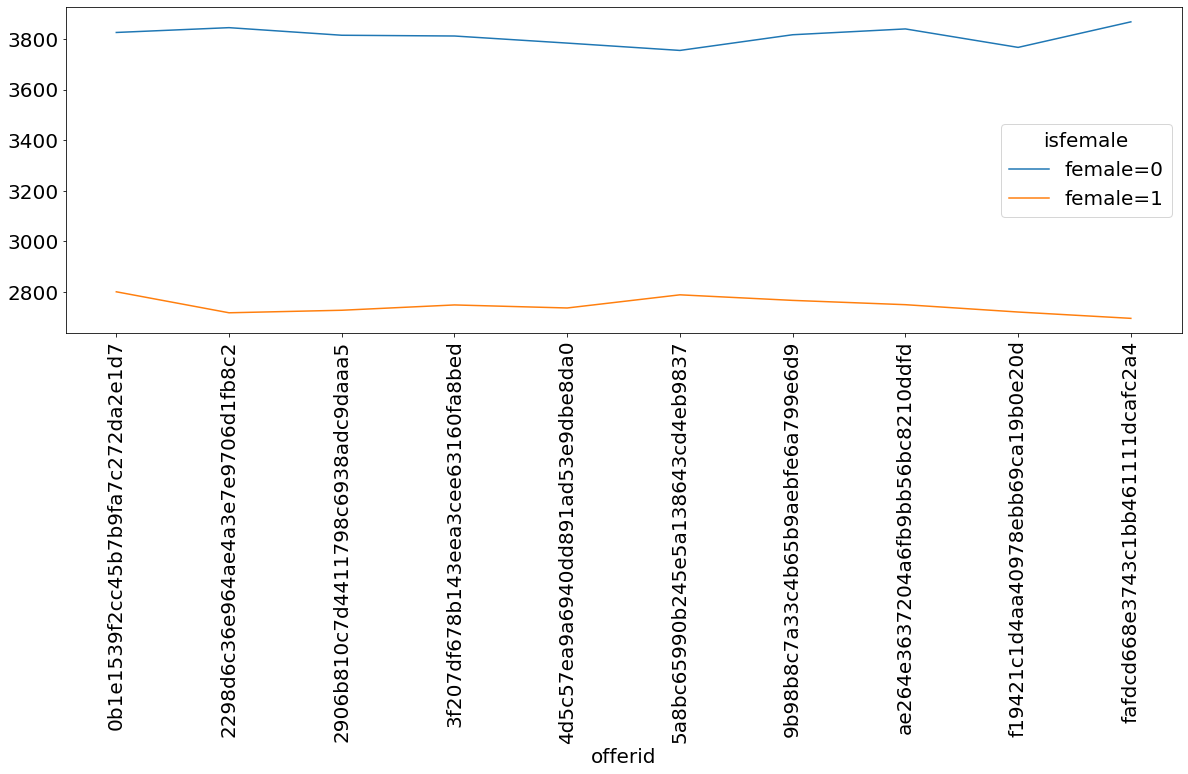

In [42]:
offerid_count = gender_offerid.pivot(index='offerid', columns='isfemale', values='count').add_prefix('female=').reset_index()
offerid_count.reset_index(drop=True, inplace=True)

plt.rc('font', size=20) 
plt.rcParams["figure.figsize"] = (20,6)
offerid_count.plot(x="offerid", y=["female=0", "female=1"])
plt.xticks(offerid_count.index, gender_offerid['offerid'], rotation=90)

### Offer Completion by Offer ID and Gender
Offer completion rate is higher for:


 **1.** BOGO and discount offers performs much better than informational advertising.
 
 
 **2.** Females have a better success rate than males, perhaps due to their relatively higher income (distribution-wise) compared to the males.

([<matplotlib.axis.XTick at 0x192ad3fe550>,
 <a list of 10 Text xticklabel objects>)

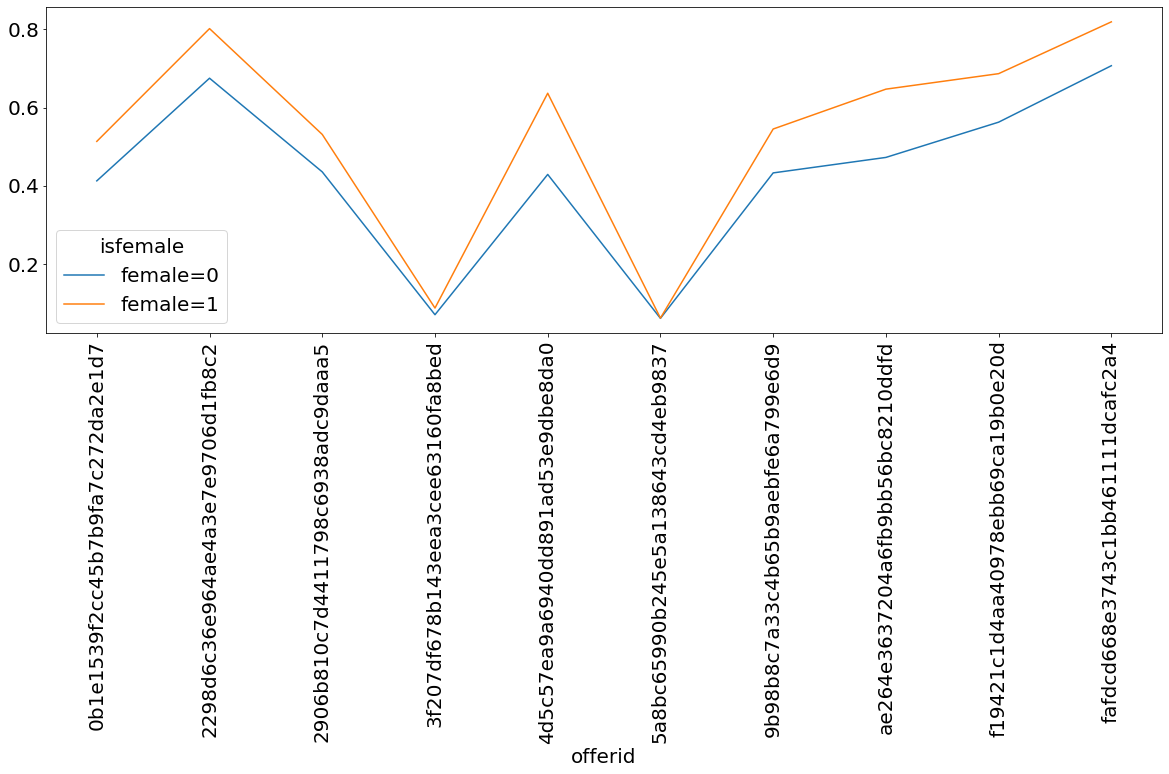

In [43]:
offerid_success = gender_offerid.pivot(index='offerid', columns='isfemale', values='mean').add_prefix('female=').reset_index()
offerid_success.reset_index(drop=True, inplace=True)

plt.rc('font', size=20) 
plt.rcParams["figure.figsize"] = (20,6)
offerid_success.plot(x="offerid", y=["female=0", "female=1"])
plt.xticks(offerid_count.index, gender_offerid['offerid'], rotation=90)

## Splitting the data : Splitting data into training and test sets

In [44]:
random_state = 123456789

class_label_name = 'offersuccessful'
variables        = clean_data.drop(columns=[class_label_name])
class_label      = clean_data.filter([class_label_name])

(X_train, X_test, y_train, y_test) = train_test_split(variables.values,
                                                      class_label.values,
                                                      test_size=0.2,
                                                      random_state=random_state)
# Remove totalamount = seem to overfit
variable_names = variables.columns[2:]

offerid_train     = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test     = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test  = y_test.ravel()

In [45]:
# Variables
print(variable_names)

Index(['difficulty', 'durationdays', 'reward', 'bogo', 'discount', 'mobile',
       'social', 'web', 'isfemale', 'income', '2013', '2014', '2015', '2016',
       '2017', '2018', '<30', '31-40', '41-50', '51-60', '61-70', '71-80',
       '>80'],
      dtype='object')


In [46]:
X_train

array([[ 7.,  7.,  3., ...,  0.,  1.,  0.],
       [ 5.,  7.,  5., ...,  0.,  0.,  0.],
       [10.,  7., 10., ...,  1.,  0.,  0.],
       ...,
       [ 0.,  4.,  0., ...,  0.,  0.,  1.],
       [20., 10.,  5., ...,  0.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.]])

In [47]:
y_train

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [48]:
type(X_train)

numpy.ndarray

# Feature scaling: Apply min/max scaling 

In [49]:
# Min-Max vs Standard Scaling
variables_to_scale = ['difficulty', 'durationdays', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values = min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values = min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

In [50]:
X_train

array([[0.35      , 0.57142857, 0.3       , ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 0.57142857, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.57142857, 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.14285714, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14285714, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
len(X_train[0])

23

# Modeling

## Model 1: Logistic Regression Model

#### Perform random search of model hyperparameter space

 * LogisticRegression model accuracy: 0.725
 * LogisticRegression model f1-score: 0.719

In [52]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score, beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

In [53]:
# Performance Evaluation Function
def evaluate_model_performance(clf,
                               X_train,
                               y_train):

    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [54]:
# Evaluate Model Performance - Train Data
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.721
LogisticRegression model f1-score: 0.715


(0.7214302050773805, 0.7149432460896361)

In [58]:
# Evaluate Model Performance - Test Data
evaluate_model_performance(lr_random.best_estimator_,
                           X_test,
                           y_test)

LogisticRegression model accuracy: 0.725
LogisticRegression model f1-score: 0.719


(0.7246321567431577, 0.7190416925948973)

## Model 2: Random Forest

#### Perform random search of model hyperparameter space

 * LogisticRegression model accuracy: 0.725 (Benchmark)
 * RandomForestClassifier model accuracy: 0.735
  
 * LogisticRegression model f1-score: 0.719 (Benchmark)
 * RandomForestClassifier model f1-score: 0.727

In [55]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

In [56]:
# Evaluate Model Performance - Train Data
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.743
RandomForestClassifier model f1-score: 0.735


(0.7431005565296943, 0.7351918429893323)

In [59]:
# Evaluate Model Performance - Test Data
evaluate_model_performance(rf_random.best_estimator_,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.735
RandomForestClassifier model f1-score: 0.727


(0.7348479072958756, 0.7274721830434101)

In [57]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123456789,
                       verbose=0, warm_start=False)


# Feature Importance

"Feature importance" is a numerical representation that helps us to draw conclusions about what features contribute most to the decision making in the Random Forrest model and helps the user to better understand the drivers behind the model.

In general, feature importance is defined as its relative contribution to the decision making of the algorithm. The feature importance is plotted on the horizontal axis,  with the ranked  feature number on the vertical axis.

These results suggest that the top five features for this problem are:

 **1.** Offer reward<br/>
 **2.** Offer difficulty (amount of spend needed to complete the offer)<br/>
 **3.** Offer duration<br/>
 **4.** Customer income<br/>
 **5.** Customers whose Starbucks app account was created in the year 2018<br/>

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

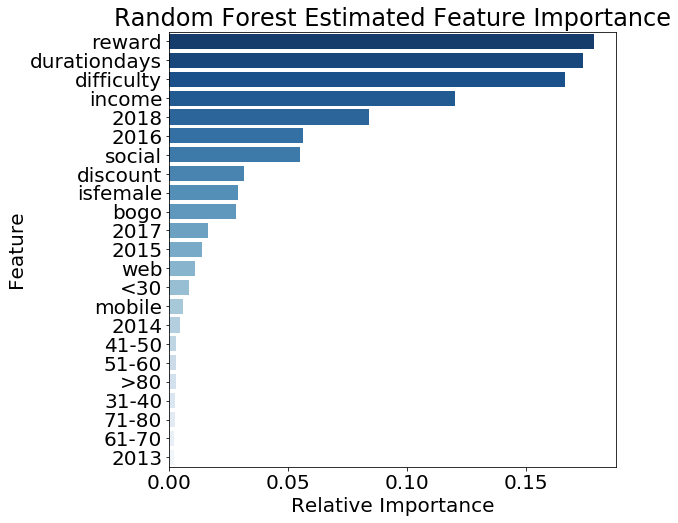

In [60]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [61]:
feature_importance.head(n=10)

,feature,relativeimportance
0,reward,0.178764
1,durationdays,0.173834
2,difficulty,0.166475
3,income,0.120184
4,2018,0.083950
5,2016,0.056085
6,social,0.055198
7,discount,0.031300
8,isfemale,0.028865
9,bogo,0.028091


# Refine Best Model Using Grid Search

 * Logistic Regression     model accuracy: 0.725 (Benchmark)
 * Random Forest  model accuracy: 0.735 (Pre-Refinement)
 * Random Forest  model accuracy: 0.739 (Post-Refinement)
  
  
 * LogisticRegression     model f1-score: 0.719 (Benchmark)
 * RandomForestClassifier model f1-score: 0.727 (Pre-Refinement)
 * RandomForestClassifier model f1-score: 0.729 (Post-Refinement)

In [69]:
print(grid_fit.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123456789,
                       verbose=0, warm_start=False)


In [67]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': 1,
                  'min_samples_split': 10,
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_random.best_estimator_,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
evaluate_model_performance(grid_fit.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.753
RandomForestClassifier model f1-score: 0.743


(0.7526301745826027, 0.7433306306484466)

In [68]:
# Evaluate Model Performance - Test Data
evaluate_model_performance(grid_fit.best_estimator_,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.739
RandomForestClassifier model f1-score: 0.729


(0.7385072806281924, 0.7294952681388013)

# Conclusion & Reflections

The project shows that even a simple Machine Learning model like Logistic Regression has the potential to increase revenues, as shown by the ability to categorize customers according to their demographics and usage behavior. 

We have also shown that a Random Forest model gave us a better performance, which is then further optimized by grid search, as summarised in the Test-scores (as opposed to Training-scores) below:

 **Accuracy : Random Forest (Grid Search) > Random Forest (Pre-Refinement) > Logistic Regression (Benchmark)**
 
 * Logistic Regression     model accuracy: 0.725 (Benchmark)
 * Random Forest  model accuracy: 0.735 (Pre-Refinement)
 * Random Forest  model accuracy: 0.739 (Post-Refinement)


 **F1-Scores : Random Forest (Grid Search) > Random Forest (Pre-Refinement) > Logistic Regression (Benchmark)**
 * Logistic Regression     model f1-score: 0.719 (Benchmark)
 * Random Forest model f1-score: 0.727 (Pre-Refinement)
 * Random Forest model f1-score: 0.729 (Post-Refinement)

Aside from model performance, 'Feature Importance' analysis shows that the Top 3 features that drives the adoption of the offers are ones that are within the control of Starbucks: Offer Reward, Offer Difficulty and Offer Duration can be tweaked to cater to the needs of its customer base. This raises the possibility that Starbucks can create more offers, each customized to fulfill the needs of different segments.

 **Feature Importance: Top 5**
1. Offer reward
2. Offer difficulty (amount of spend needed to complete the offer)
3. Offer duration
4. Customer income
5. Customers whose Starbucks app account was created in the year 2018

# Room for Improvement

The outcome of the project is achieved via minimal amount of data, data preprocessing and the application of simple algorithms.

If time allows we could delve further into:

 **1.** Enriching data by creating new features like the Day/hour the offer received/viewed/completed. With the assumption that users may pay less attention to the app when they are working, etc.
 
 **2.** More data preprocessing and transformation which could include: 
 
  * Further identifying/removing data anomalies to reduce potential bias caused by these data points.
 
  * Other feature scaling like sklearn.preprocessing.RobustScaler instead of a simple min/max method, 
 
  * Data augmentation/transformation to have a more normally distributed data that would have improved our benchmark Logistic Regression performance.
  
  * More robust metrics other than F1-scores since it gives equal importance to precision and recall. In practice, different types of mis-classifications incur different costs. More time would have been devoted to understand business nuances like this.

All these extra steps above could have potentially give us a more accurate and robust model compared to the current solution.